In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pymongo import MongoClient
client = MongoClient('localhost', 27017)
%matplotlib inline

db = client['facebook']
friends_table = db['friends']
rmfriends_table = db['removed_friends']
post_com_table = db['posts_and_comments']
search_hist_table = db['your_search_history']
profile_table = db['profile_information']
location_table = db['location_history']
login_loc_table = db['where_you_login_from']
profile_update_table = db['profile_update_history']
login_out_table = db['logins_and_logouts']

db.list_collection_names()

['removed_friends',
 'comments',
 'posts_and_comments',
 'sent_friend_requests',
 'news_topics_for_recommendations',
 'notes',
 'your_search_history',
 'unfollowed_pages',
 'likes_on_external_sites',
 'location_history',
 'used_ip_addresses',
 'facebook_watch_topics_for_recommendations',
 'profile_information',
 'people',
 'menu_items',
 'account_activity',
 'where_you_login_from',
 'rejected_friend_requests',
 'friends',
 'last_location',
 'recieved_friend_requests',
 'profile_update_history',
 'news_feed_topics_for_recommendations',
 'logins_and_logouts',
 'primary_location',
 'followers',
 'pages',
 'following']

In [2]:
print("Facebook has recorded {} people I'm friends with.".format(str(len(friends_table.find_one()['friends']))))

Facebook has recorded 836 people I'm friends with.


In [13]:
#print(location_table.find_one()['location_history'])
print("Facebook has {} location points on me.".format(str(len(location_table.find_one()['location_history']))))

Facebook has 14512 location points on me.


In [4]:
#print(login_loc_table.find_one())
print("Facebook has recorded me logging in from {} locations".format(str(len(login_loc_table.find_one()['active_sessions']))))

Facebook has recorded me logging in from 14 locations


In [5]:
#print(search_hist_table.find_one()['searches'])
print("Facebook has recorded {} of my searches.".format(str(len(search_hist_table.find_one()['searches']))))

Facebook has recorded 891 of my searches.


In [6]:
len(login_out_table.find_one()['account_accesses'])
print("Facebook has tracked my logins from {} different locations.".format(str(len(login_out_table.find_one()['account_accesses']))))

Facebook has tracked my logins from 13 different locations.


In [7]:
# Digging into the location data
location_df = pd.DataFrame(location_table.find_one()['location_history'])

In [8]:
location_df.head()

,coordinate,creation_timestamp,name
0,"{'latitude': 37.75698, 'longitude': -122.42097}",1569600790,San Francisco
1,"{'latitude': 37.75703, 'longitude': -122.42094}",1569587385,San Francisco
2,"{'latitude': 37.7571, 'longitude': -122.42098}",1569559743,San Francisco
3,"{'latitude': 37.75712, 'longitude': -122.42099}",1569535934,San Francisco
4,"{'latitude': 37.75713, 'longitude': -122.42098}",1569452781,San Francisco


In [135]:
#getting the data into a useable format

location_df['ts'] = pd.to_datetime(location_df['creation_timestamp'], unit='s')
location_tm_df = location_df.sort_values('ts')
location_tm_df.head()
coordinates_list = list(location_tm_df['coordinate'])
print(coordinates_list[:5])
lat_list, lng_list, ts_list = ([] , [], [])
for itm in coordinates_list:
    lat_list.append(itm['latitude'])
    lng_list.append(itm['longitude'])
for tm in list(location_tm_df['ts']):
    ts_list.append(tm)
lat_series = pd.Series(lat_list)
lng_series = pd.Series(lng_list)
print(ts_list[:5])
#location_df['lat'].append(lat_series, ignore_index=True)
#location_df['lng'].append(lng_series, ignore_index=True)


location_df.head()

[{'latitude': 37.76567, 'longitude': -122.40763}, {'latitude': 37.7842, 'longitude': -122.41584}, {'latitude': 37.77974, 'longitude': -122.41416}, {'latitude': 37.73317, 'longitude': -122.43378}, {'latitude': 37.72295, 'longitude': -122.44703}]
[Timestamp('2014-05-25 18:59:53'), Timestamp('2014-05-26 17:19:47'), Timestamp('2014-05-26 18:32:17'), Timestamp('2014-05-26 18:49:22'), Timestamp('2014-05-26 18:51:19')]


,coordinate,creation_timestamp,name,ts
0,"{'latitude': 37.75698, 'longitude': -122.42097}",1569600790,San Francisco,2019-09-27 16:13:10
1,"{'latitude': 37.75703, 'longitude': -122.42094}",1569587385,San Francisco,2019-09-27 12:29:45
2,"{'latitude': 37.7571, 'longitude': -122.42098}",1569559743,San Francisco,2019-09-27 04:49:03
3,"{'latitude': 37.75712, 'longitude': -122.42099}",1569535934,San Francisco,2019-09-26 22:12:14
4,"{'latitude': 37.75713, 'longitude': -122.42098}",1569452781,San Francisco,2019-09-25 23:06:21


2015-09-28    401
2015-10-06    225
2015-09-21    209
2015-09-22    199
2014-06-18    143
Name: ts, dtype: int64


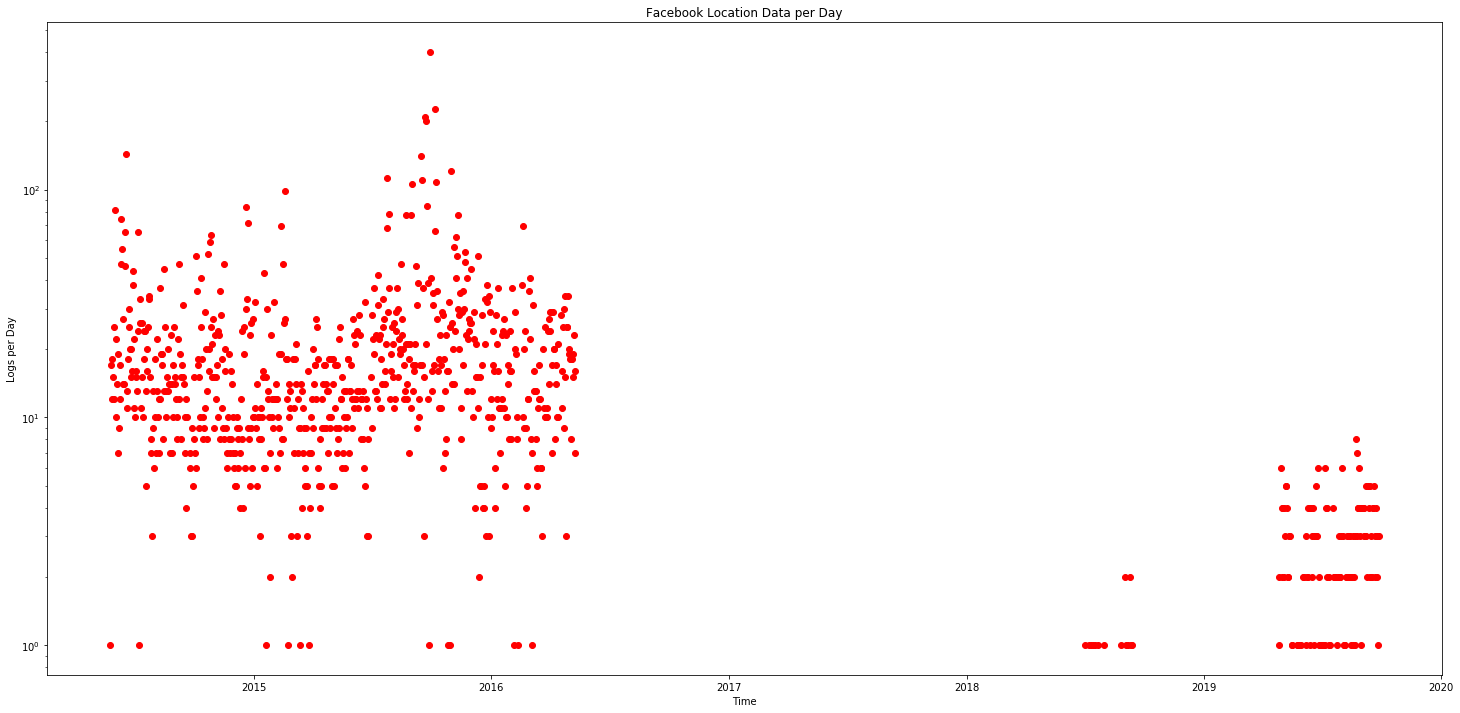

In [136]:
# Plotting location logs per day over time 
from datetime import datetime
fig, ax = plt.subplots(figsize=(25,12))

time2 = location_df['ts'].dt.floor('D')
time3 = time2.value_counts()
print(time3[:5])

a=list(time3.index.to_pydatetime())
b=list(time3)
lst=[(a[i],b[i]) for i in range(len(b))]
lst.sort()
x=[i[0] for i in lst]
y=[i[1] for i in lst]

#plt.ylim(top=40)
plt.title('Facebook Location Data per Day')
plt.xlabel('Time')
plt.ylabel('Logs per Day')
plt.yscale('log')
ax.plot(x,y, 'ro')
plt.savefig('location_tracking_over_time5.png')

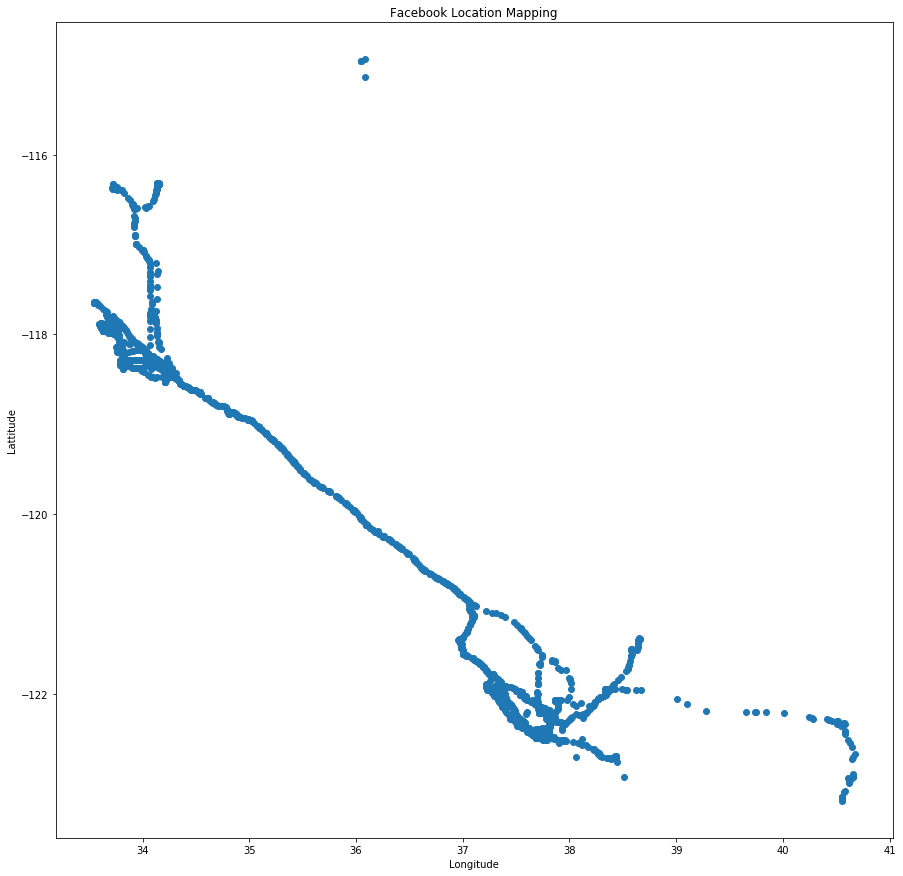

In [11]:
fig, ax = plt.subplots(figsize=(15,15))

plt.title('Facebook Location Mapping')
plt.xlabel('Longitude')
plt.ylabel('Lattitude')
ax.plot(lat_list,lng_list, 'o')
plt.savefig('raw_location_plot2.png')

In [126]:
import folium
import geopandas as gpd
from folium import plugins

point_lst=[(lat_list[i],lng_list[i]) for i in range(len(lng_list))]

map_all = folium.Map(tiles='OpenStreetMap', location=[np.mean(lat_list), np.mean(lng_list)], zoom_start=6)
map_all.add_child(plugins.HeatMap(data=point_lst))

In [137]:
map_all = folium.Map(tiles='OpenStreetMap', location=[np.mean(lat_list), np.mean(lng_list)], zoom_start=6)
map_all.add_child(plugins.PolyLineOffset(locations=point_lst))

In [30]:
searches_df = pd.DataFrame(search_hist_table.find_one()['searches'])
searches_df['ts'] = pd.to_datetime(searches_df['timestamp'], unit='s')
searches_df.head()

,attachments,data,timestamp,title,ts
0,"[{'data': [{'text': '""alexis rutledge""'}]}]",[{'text': 'alexis rutledge'}],1584715731,You searched Facebook,2020-03-20 14:48:51
1,"[{'data': [{'text': '""stu kosh""'}]}]",[{'text': 'stu kosh'}],1584065477,You searched Facebook,2020-03-13 02:11:17
2,"[{'data': [{'text': '""Anna Laclergue""'}]}]",[{'text': 'Anna Laclergue'}],1581373518,You searched Facebook,2020-02-10 22:25:18
3,"[{'data': [{'text': '""Anna Laclergue""'}]}]",[{'text': 'Anna Laclergue'}],1581373497,You searched Facebook,2020-02-10 22:24:57
4,"[{'data': [{'text': '""anna laclergue""'}]}]",[{'text': 'anna laclergue'}],1581373495,You searched Facebook,2020-02-10 22:24:55


In [98]:
searches_list = list(searches_df['data'])
#print(searches_list[:5])
searches_txt = []
for search in searches_list:
    if not isinstance(search,float):
        #print(search)
        for itm in search:
            if 'text' in itm:
                searches_txt.append(itm['text'].lower())
#print(searches_txt)

In [139]:
searchCount_dict = {}
for search in searches_txt:
    if search in searchCount_dict:
        searchCount_dict[search] += 1
    else:
        searchCount_dict[search] = 1
print(len(searchCount_dict), "\n")
#print(searchCount_dict)
#sorted_search_dict = sorted(searchCount_dict.values(), reverse=True)
#print(sorted_search_dict)
#print(sorted(searchCount_dict.values(), reverse=True))
# for k, v in sorted(searchCount_dict.items(), reverse=True) :
#      print(k , " ::" , v )

483 



In [104]:
# diana carr(29), removed from reality(16), alexis rutlidge(15), chris riggins(13), arg zombies(12), brett icus(9), 
# eco(9), removed from reality: afghanistan and back(9), kaseem bentley(9), neo(8), jackson mcbrayer(8)

In [138]:
word_df = pd.DataFrame(searchCount_dict, index=[0]).transpose().sort_values(by=0, ascending=False)
word_df.head(200)

,0
diana carr,29
removed from reality,16
alexis rutledge,15
chris riggins,13
arg zombies,12
removed from reality: afghanistan and back,9
brett icus,9
eco,9
kaseem bentley,9
david o'hagan,8
